---
title: "Order statistics — Part 1: Introduction and definitions"
date: 2021-03-05
categories: [statistics, order statistics]
tags: [statistics, order statistics, uniform distribution, FTC]
preview_image: /enrightward.github.io/assets/img/order-statistics/part1/running-a-race.jpg
---

![Desktop View](/assets/img/order-statistics/part1/running-a-race.jpg)

## 1. Introduction

On average, how tall is the tallest 8th grader in a class of 30 students, in the US? What is the value of the average winning bid in a [Vickery Auction](https://en.wikipedia.org/wiki/Vickrey_auction), where the highest bidder wins, but must pay only the second-highest bid? A common statistical approach here is:

1. Assume the empirical data $x_{1}, \ldots, x_{n}$ (heights, bids, etc.) are sampled from iid random variables $X_{1}, \ldots, X_{n}$;
2. Model the underlying PDF as $f$, then;
3. Compute _order statistics_ — defined rigorously in the next section — but for example, the expectation of the maximum (or second-largest, or third-largest) value of the $X_{i}$.

## 2. A toy problem

To investigate such questions, we'll start with a concrete, toy problem. Recall the uniform distribution $U(0,1)$ on the unit interval: Its PDF takes constant value $1$ on the closed interval $[0, 1]$, and is zero everywhere else. Consider the following toy question: Suppose $X_{1}$ and $X_{2}$ are random variables, independently sampled from $U(0,1)$. What is the expected value of the minimum of $X_{1}$ and $X_{2}$? What about the maximum? If there is a third such random variable $X_{3}$, how do these numbers change, and what's the expected middle value?

## 3. Outline

In this post, I will explore the simplest setting of these questions, where we have only two random variables $X_{1}$ and $X_{2}$, sampled from $U(0,1)$. I will do this first empirically, using numpy computations, then theoretically, using mathematics. These kinds of questions fall under the heading of [Order Statistics](https://en.wikipedia.org/wiki/Order_statistics).

In the [next post](https://enrightward.github.io/enrightward.github.io/posts/order-statistics-part-2/), I will discuss similar expectation results for the general case of $n$ iid random variables $X_{1}, \ldots, X_{n}$ and an arbitrary PDF $f$. It turns out we can write down a general formula for the expectation of $k^{\textrm{th}}$-largest of the $X_{i}$, provided we know the associated CDF $F$. This formula will be especially nice in the case where $f$ is the uniform distribution.

## 4. Notation

We define some general notation for convenience. For a set $S = \{ X_{1}, \ldots, X_{n} \}$ of iid random variables, say with arbitrary common PDF $f$, denote by $X_{(1)}, \ldots, X_{(n)}$ their rearrangement in ascending order:

\begin{equation}
X_{(1)} \le X_{(2)} \le \ldots \le X_{(n)}.
\end{equation}

Thus, in particular, $X_{(1)} = \min(S)$ and $X_{(n)} = \max(S)$. We call $X_{(k)}$ the _$k$-th order statistic_. Our goal will be to compute formulae for $\mathbb{E}(X_{(k)})$, for any $k$. It will turn out we can do this for general $f$, provided we know the associated CDF, $F$. 

We'll begin, however, with some concrete calculations of sample $k$-th order statistics in the case where $f \sim U(0, 1)$. As a first step, we define two functions: One to repeately sample $n$-tuples from $U(0, 1)$, for arbitary $n$, and another to estimate the expectations of order statistics associated to these samples.

In [1]:
import numpy as np

def sample_uniform(n, m):
    """Sample an `n`-tuple `m` times from the 
    uniform distribution on the unit interval"""
    return [np.random.random(n) for _ in range(m)]

def sample_mean_order_statistic(xs, k):
    """Returns the mean of the `k`-th (sample) order statistic of `xs`. 
    Here, `xs` is a list of np.arrays, each of the same length `n`. 
    The positive integer `k` must satisfy 1 <= k <= `n`."""
    # Require every array `x` in `samples` has the same length `n`.
    n = len(xs[0])
    assert(set([len(x) for x in xs]) == set([n]))
    # Require `k` is between 1 and `n`.
    assert(1 <= k and k <= n)
    x_ks = []
    
    for x in xs:
        # sort each x in ascending order to find x_(k) 
        # NB: Array zero indexing => map k to k-1.
        x_k = sorted(x)[k - 1]
        x_ks.append(x_k)
        
    x_ks = np.array(x_ks)
    return x_ks.mean()

## 5. A numerical investigation, for small $n$

We can use these two functions to estimate expected values for the $X_{(k)}$, for different values $n$, as follows:

1. Sample $m$ lots of an $n$-tuple $(x_{1}, \ldots, x_{n})$, where each $x_{i}$ is sampled from the uniform distribution on the unit interval, using the function `sample_uniform`.
2. Estimate the $\mathbb{E}(X_{(k)})$ via sample means, using the function `sample_mean_order_statistic`.

The idea is that if we choose the number of samples "$m$" from Step 1 to be large enough, the estimates in Step 2 will be as accurate as we like.

As a first application of this two-step procedure, let's try to answer, empirically, the first toy question from the introduction: What are the expected maximum and minimum values of two independent random variables $X_{1}, X_{2} \sim U(0, 1)$?

In [2]:
# lots of samples for accurate sample expectations
m = 10000

# try n = 2
n = 2
xs = sample_uniform(n, m)

Ex_1 = sample_mean_order_statistic(xs, k=1)
Ex_2 = sample_mean_order_statistic(xs, k=2)

print('E(min(X_1, X_2)) ~ {:.5f}'.format(Ex_1))
print('E(max(X_1, X_2)) ~ {:.5f}'.format(Ex_2))

E(min(X_1, X_2)) ~ 0.33327
E(max(X_1, X_2)) ~ 0.66649


A good guess might be that $\mathbb{E}(X_{\textrm{min}}) = 1/3$ and $\mathbb{E}(X_{\textrm{max}}) = 2/3$. This doesn't seem crazy: For one thing, it would mean $\mathbb{E}(X_{\textrm{min}})$ and $\mathbb{E}(X_{\textrm{max}})$ are equispaced along the unit interval. Equispacing is also consistent with the following observation: Since you can think of a single $X_{1} \sim U(0, 1)$ as a "very short" collection of random variables, with the property that $X_{\textrm{min}} = X_{\textrm{max}} = X_{1}$, we have:

\begin{align}
\mathbb{E}(X_{\textrm{min}}) = \mathbb{E}(X_{1}) = \mathbb{E}(X_{\textrm{max}}) = 1/2.
\end{align}

That is, $\mathbb{E}(X_{1})$ partitions $[0, 1]$ into two equal subintervals. Does this equispacing story generalise to $n$ variables? Let's push on and repeat the numerical experiment, this time with three random variables $X_{1}, X_{2}$ and $X_{3}$. For convenience, I'll also wrap the preceding cell in a function, so in future I can compute and print such estimates in one line of code.

In [3]:
def compute_expected_order_estimates(n, verbose=True):
    """Compute, and optionally print the estimated expected 
    values for the kth order statistics of `n` independent 
    random variables on U(0, 1)."""
    
    # We'll fix `m` to be large.
    m = 10000
    xs = sample_uniform(n, m)
    Ex_ks = []
    
    # Estimate and (optionally) print statistics.
    for k in range(1, n + 1):
        Ex_k = sample_mean_order_statistic(xs, k)
        Ex_ks.append(Ex_k)
    
        if verbose:
            print('E[X_({})] ~ {:.5f}'.format(k, Ex_k))
        
    return Ex_ks

Now let's use this function to estimate the order statistics on three random variables:

In [4]:
Ex_ks = compute_expected_order_estimates(n=3, verbose=True)

E[X_(1)] ~ 0.24874
E[X_(2)] ~ 0.50294
E[X_(3)] ~ 0.75110


This time, it seems perhaps that

\begin{align}
\mathbb{E}(X_{(1)}) = \frac{1}{4}, \quad \mathbb{E}(X_{(2)}) = \frac{1}{2} \quad \textrm{and} \quad 
\mathbb{E}(X_{(3)}) = \frac{3}{4},
\end{align}

also an equispaced pattern along $[0, 1]$. It's tempting to conjecture that for $n$ random variables $X_{1}, \ldots, X_{n}$, the expecations of the $k$-th order statistics $X_{(1)}, \ldots, X_{(n)}$ partition the unit interval into $n+1$ equal subintervals. If so, we would have:

\begin{align}
\mathbb{E}(X_{(k)}) = \frac{k}{n+1}, \quad \textrm{for all} \quad 1 \le k \le n.
\end{align}

To gain confidence in this hypothesis, I'll repeat the calculation one final time, for a slightly larger range of $n$ values. To make the results more readable, I'll display the esimated $\mathbb{E}(X_{(k)})$ values in a collection of bar plots, one for each $n$, rather than just spam the screen with printed floats. To this end, the next cell  defines "boilerplate" plotting code. Some attribution is in order: The `label_bars` code, which prints the values of each bar in a bar chart, is copy-pasted verbatim from [SaturnFromTitan](https://stackoverflow.com/users/7066758/saturnfromtitan)'s answer to a [StackOverflow question](https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh) on barplot labelling.

In [5]:
from matplotlib import pyplot as plt

def set_ax_colour(ax, colour):
    """Set the spine, label and ticks of the 
    axis colour to `colour`"""
    ax.spines['bottom'].set_color(colour)
    ax.spines['top'].set_color(colour)
    ax.spines['left'].set_color(colour)
    ax.spines['right'].set_color(colour)
    ax.xaxis.label.set_color(colour)
    ax.yaxis.label.set_color(colour)
    ax.title.set_color(colour)
    ax.tick_params(axis='x', colors=colour)
    ax.tick_params(axis='y', colors=colour)

def label_bars(ax, bars, text_format, **kwargs):
    """
    Attaches a label on every bar of a regular or horizontal bar chart
    """
    ys = [bar.get_y() for bar in bars]
    y_is_constant = all(y == ys[0] for y in ys)  # -> regular bar chart, since all all bars start on the same y level (0)

    if y_is_constant:
        _label_bar(ax, bars, text_format, **kwargs)
        
    else:
        _label_barh(ax, bars, text_format, **kwargs)

def _label_bar(ax, bars, text_format, **kwargs):
    """
    Attach a text label to each bar displaying its y value
    """
    max_y_value = ax.get_ylim()[1]
    inside_distance = max_y_value * 0.1
    outside_distance = max_y_value * 0.01

    for bar in bars:
        text = text_format.format(bar.get_height())
        text_x = bar.get_x() + bar.get_width() / 2
        is_inside = bar.get_height() >= max_y_value * 0.15
        
        if is_inside:
            color = 'white'
            text_y = bar.get_height() - inside_distance
            
        else:
            color = 'black'
            text_y = bar.get_height() + outside_distance

        ax.text(text_x, text_y, text, ha='center', va='bottom', color=color, **kwargs)

def _label_barh(ax, bars, text_format, **kwargs):
    """
    Attach a text label to each bar displaying its y value
    Note: label always outside. otherwise it's too hard to control as numbers can be very long
    """
    max_x_value = ax.get_xlim()[1]
    distance = max_x_value * 0.0025

    for bar in bars:
        text = text_format.format(bar.get_width())
        text_x = bar.get_width() + distance
        text_y = bar.get_y() + bar.get_height() / 2
        ax.text(text_x, text_y, text, va='center', **kwargs)   

def multi_bar_plot(axs, func, fontsizefunc, colour, tickfontsize, titlefontsize):
    """Wrapper function to plot the output of `func` 
    on matplotlib axes `axs`."""

    for i, ax in enumerate(axs):
        set_ax_colour(ax, colour)
        n = i+1
        values = func(n)
        x_ticks = list(range(1, n+1))
        width = n/(n+1)
        bars = ax.bar(x_ticks, values, width, align='center')
        ax.set_title('n = {}'.format(n), fontsize=titlefontsize)
        ax.set_ylim([0.0, 1.0])   
        ax.set_xticks(x_ticks)
        ax.tick_params(axis='both', labelsize=tickfontsize)
        value_format = '{:.2}'
        kwargs = {'fontweight': 'bold', 'fontsize': fontsizefunc(n)}
        label_bars(ax, bars, value_format, **kwargs)

## 6. Plotting numerical results for $1 \le n \le 9$

Now we display in barplots, for each $1 \le n \le 9$, estimates for the $\mathbb{E}(X_{(k)})$, for all $1 \le k \le n$.

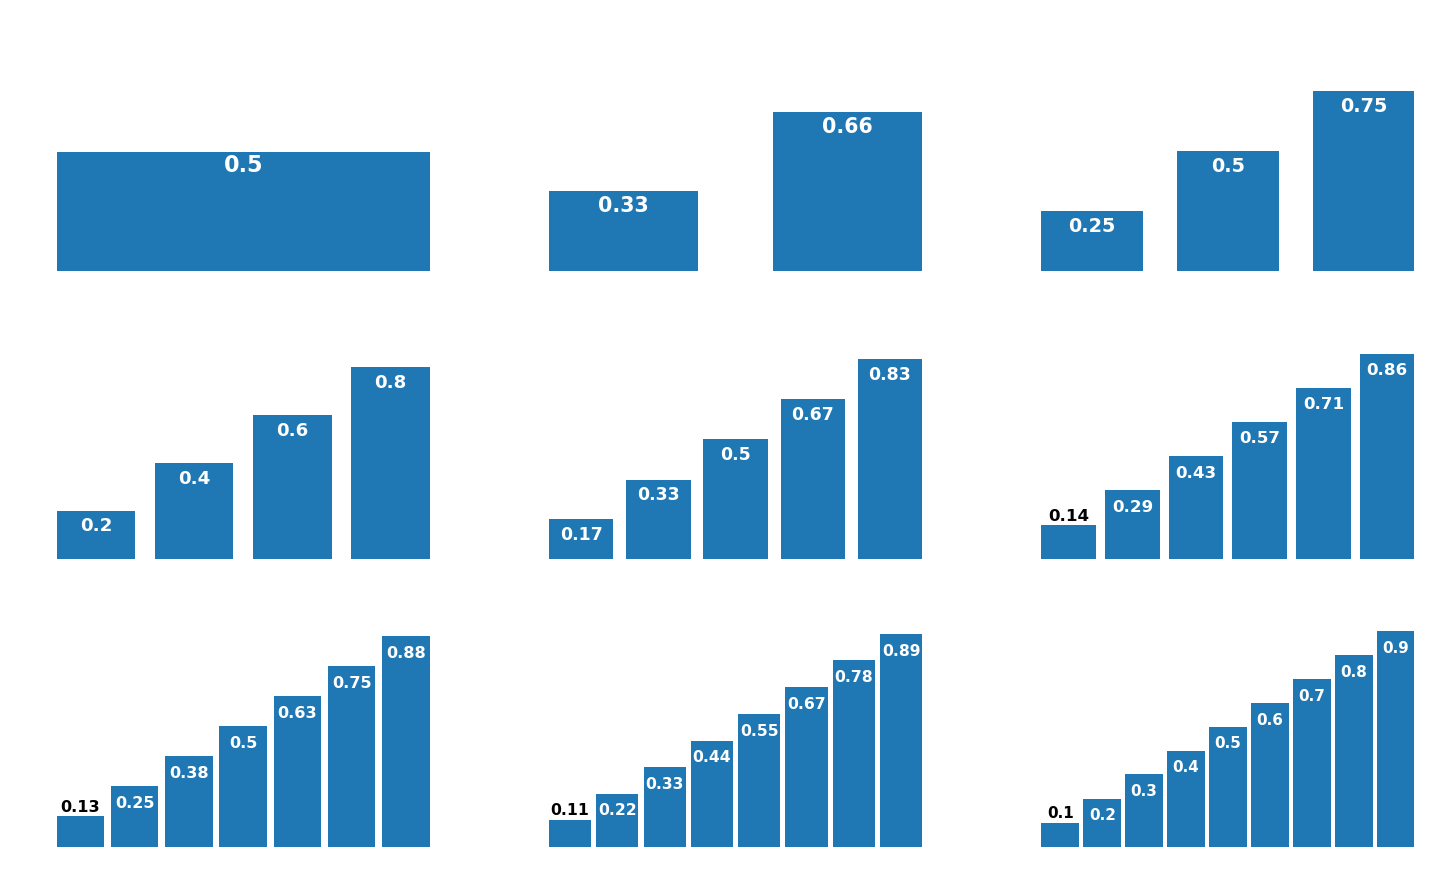

In [6]:
height = 3
width = 3

figsize = (25, 15)
fig, axs = plt.subplots(height, width, figsize=figsize)
axs = axs.flatten()
colour = 'white'
func = lambda n: compute_expected_order_estimates(n, verbose=False)
fontsizefunc = lambda n: 40 * (1/np.log(n+5))
tickfontsize = 15 
titlefontsize = 25
multi_bar_plot(axs, func, fontsizefunc, colour, tickfontsize, titlefontsize)

![png](/assets/img/order-statistics/part1/order_stats_bar_plots.png)

## 7. A mathematical analysis, for small $n$

The barplots above look equispaced in all cases — the hypothesis that:

\begin{align}
\mathbb{E}(X_{(k)}) = \frac{k}{n+1}
\end{align}

is looking good, experimentally. How can we prove it mathematically? Let's begin by returning to small values of $n$. In the case $n = 1$, it amounts to saying that the expectation of $X_{1} \sim U(0, 1)$ is $1/2$, as we observed above.  This is easily shown: Recalling that the associated PDF $f_{X_{1}}(x)$ is equal to $1$ on $[0, 1]$ and zero everywhere else, we have, by definition of expectation:

\begin{align}
\mathbb{E}(X_{1}) = \int_{0}^{1} x \, f_{X_{1}}(x) \, dx = \int_{0}^{1} x \, dx = 
\left \lbrack \frac{x^{2}}{2} \right \rbrack_{0}^{1} = \frac{1}{2} \cdot
\end{align}

Consider now the case $n = 2$, where $X_{1}, X_{2} \sim U(0, 1)$. To compute the expectations of $X_{(1)} = \min(X_{1}, X_{2})$ and $X_{(2)} = \max(X_{1}, X_{2})$, we must first be able to write down the PDFs $f_{X_{(1)}}(x)$ and $f_{X_{(2)}}(x)$. In cases such as this — where a new random variable is defined indirectly, as a function of already-defined random variables — it's often easier to first deduce the associated CDF (which we'll denote here by capitalising $f$ to $F$), since it relates more directly to probabilities. Indeed, for a general random variable $X$, defined on the real line, one has that

\begin{align}
\mathbb{Pr}(X \le x) = F_{X}(x) := \int_{-\infty}^{x} f_{X}(t) \, dt,
\end{align}

and hence by the [Fundamental Theorem of Calculus](https://en.wikipedia.org/wiki/Fundamental_theorem_of_calculus) (FTC) that 

\begin{align}
F_{X}(x) = \int_{-\infty}^{x} f_{X}(t) \, dt \quad \Longrightarrow \quad f_{X}(x) = \frac{d}{dx}(F_{X}(x)).
\end{align}

In our case, for a real number $x$ in the unit interval, we have both

\begin{align}
\mathbb{Pr}(\min(X_{1}, X_{2}) \le x) = F_{X_{(1)}}(x),
\end{align}

and a corresponding statement for $F_{X_{(2)}}(x)$. The probability $\mathbb{Pr}(\min(X_{1}, X_{2}) \le x)$ can be interpreted as the area of a subregion of the unit square $[0, 1] \times [0, 1]$ in the $X_{1} X_{2}$ plane. We use the code in the next cell to visualise this subregion.

In [7]:
def order_filter_2d(samples, k, limit):
    """Given a 2-dimensional, 2 x N numpy array `samples`, an integer 
    `k` in {0, 1, 2} and a real number `limit` in [0, 1], returns the 
    2 x M subarray of `samples` for which each column vector has exactly 
    `k` entries <= `limit`."""
    # `k` must be an integer in {0, 1, 2}.
    assert k >= 0 and k <= 2
    filtered_samples = []
    
    # sample is a 2 x N array => sample.transpose() is 
    # N X 2, so its elements are 2D.
    for sample in samples.transpose():
        x, y = sample
        # how many of {x, y} are <= `limit`?
        num_lte_limit = sum([x <= limit, y <= limit])

        # if this number equals `k`, add the sample
        if num_lte_limit == k:
            filtered_samples.append([x, y])
    
    return np.array(filtered_samples)

def set_ax_values(ax, limit):
    """Helper function to label `ax`."""
    ax.set_xlabel('X_1')
    ax.set_ylabel('X_2')
    plt.title('Regions where X_(k) < {}, colour-coded by k in [0, 1, 2]'.format(limit))

def plot_2d(region_samples, dotwidth, limit):
    """Given a list `region_samples` of 2 x N numpy arrays living 
    in [0, 1] x [0, 1], plot the 2D points in each array with a 
    separate colour scheme. Each point has thickness `dotwidth` 
    and `limit` is used only to label the graph."""
    colour = 'white'
    fig, ax = plt.subplots(figsize=(12, 10))
    set_ax_colour(ax, colour)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    set_ax_values(ax, limit)
    cmaps = ['magma', 'viridis', 'winter']
    
    # display each region_sample in `region_samples`
    # on the same axis, but with a separate colour scheme.
    for i, region_sample in enumerate(region_samples):
        xs = region_sample[:, 0]
        ys = region_sample[:, 1]
        cmap = cmaps[i % len(cmaps)]
        #ax.scatter(xs, ys, c=xs+ys, cmap=cmap, linewidth=dotwidth, alpha=0.5)
        ax.scatter(xs, ys, c=np.array([xs.mean()]*len(xs)), cmap=cmap, linewidth=dotwidth, alpha=0.5)
    
    plt.show()

## 8. Visualising $\mathbb{Pr}(X_{(k)} \le x)$ in the plane

Let's use the above code to visualise the regions where $X_{(k)} \le x$, for $k = 1, 2$. The areas of these regions will be the probabilities $\mathbb{Pr}(X_{(k)} \le x)$. 

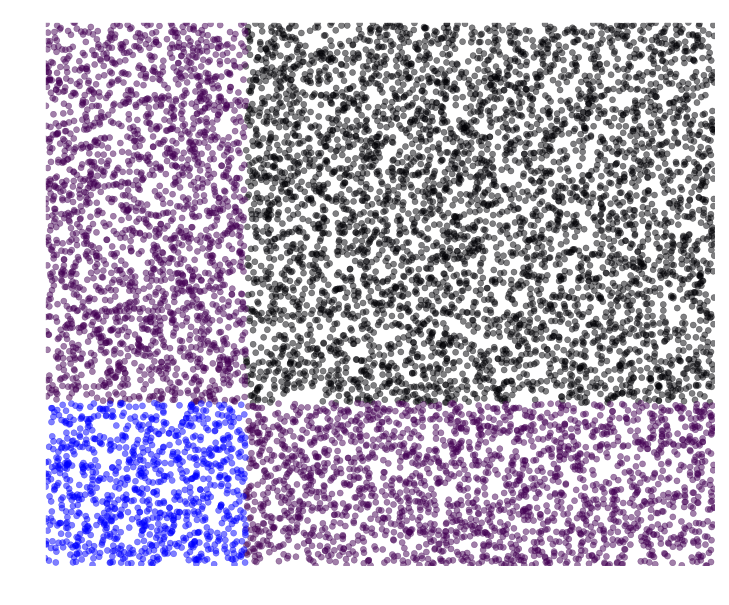

In [8]:
# sample 10,000 points to cover the unit square
num = int(1e4)
dotwidth = 0.5
samples = np.random.random((2, num))

# we're interested in which points have zero, one 
# or two coordinates <= 0.3
limit = 0.3
ks = [0, 1, 2]
region_samples = []

# For each k in [0, 1, 2], filter for the the 2D columns in 
# `samples` having exactly `k` coordinates <= 0.3.
for k in ks:
    filtered_samples = order_filter_2d(samples, k, limit)
    region_samples.append(filtered_samples)

plot_2d(region_samples, dotwidth, limit)

![png](/assets/img/order-statistics/part1/order_stats_2d.png)

## 9. Analysing the visulation: Computing CDFs

In the scatter plot above, we uniformly sampled 10,000 points $P = (x_{1}, x_{2})$ from the unit square, and coloured them according to whether none, only one, or both of the coordinates $x_{1}$ and $x_{2}$ of $P$ were less than the (arbitrarily-chosen) cutoff value $x = 0.3$. Specifically:

1. The blue square region in the bottom-left corner is all the points for which $x_{1} \le x$ and $x_{2} \le x$. Call this region $R_{2}$, because both inequalities hold.
2. The two purple rectangular regions along the axes are all the points for which either $x_{1} \le x$ or $x_{2} \le x$, but not both. Call this region $R_{1}$, because only one inequality holds.
3. The large black square region in the top-right is all the points for which neither $x_{1} \le x$ nor $x_{2} \le x$ holds. Call this region $R_{0}$, since neither inequality holds.

Denote by $A_{i}$ the area of the region $R_{i}$. The $A_{i}$ are easy to compute, because they are areas of squares or rectangles with known sides of length $x$ or $1-x$: $A_{2} = x^{2}$, $A_{0} = (1-x)^{2}$ and $A_{1} = 2x(1-x)$. Note also that $A_{i}$ represents the probability that the coordinates of a randomly-sampled $P$ will satisfy the inequalities defining $R_{i}$. For example,

\begin{align}
\mathbb{Pr}(X_{1}, X_{2} \le x) = A_{2} = x^{2}.
\end{align}

I claim this means we can also use the $A_{i}$ to calculate the probabilities $\mathbb{Pr}(X_{(k)} \le x = 0.3)$, for $k = 1, 2$. To see this, observe that

\begin{align}
X_{(1)} = \min(X_{1}, X_{2}) \le X_{1}, X_{2} \le \max(X_{1}, X_{2}) = X_{(2)}.
\end{align}

This inequality shows that the condition $X_{(2)} \le x$ is equivalent to requiring both $X_{1} \le x$ and $X_{2} \le x$. It follows that

\begin{align}
\mathbb{Pr}(X_{(2)} \le x) = \mathbb{Pr}(X_{1}, X_{2} \le x) = x^{2}.
\end{align}

We can also compute $\mathbb{Pr}(X_{(1)} \le x)$ like this, though it is a little more work. The difference is that there are more orderings of $X_{1}$, $X_{2}$ and $x$ that are relevant to the calculation. Indeed, consider the three inequality chains

\begin{align}
X_{(1)} &= X_{1} \le x \le X_{2} = X_{(2)} \newline
X_{(1)} &= X_{2} \le x \le X_{1} = X_{(2)} \newline
X_{(1)} &\le X_{(2)} \le x.
\end{align}

This is a non-overlapping, exhaustive list arrangements of $X_{1}, X_{2}$ and $x$ satisfying the condition $X_{(1)} \le x$. It follows that the sum of areas of the regions they describe equals $\mathbb{Pr}(X_{(1)} \le x)$. What are these regions? The first two of these chains correspond to the two purple rectangles, which we denoted (jointly) by $R_{1}$. The last chain is the same as the one considered in the $\mathbb{Pr}(X_{(2)} \le x)$ calculation, and corresponds to $A_{2}$. It follows that 

\begin{align}
\mathbb{Pr}(X_{(1)} \le x) = A_{1} + A_{2} = 2x(1-x) + x^{2} = 2x - x^{2}.
\end{align}

## 10. Deriving PDFs from CDFs using the FTC

We have just computed:

\begin{align}
F_{X_{(1)}}(x) &= \mathbb{Pr}(X_{(1)} \le x) = 2x - x^{2}, \quad \textrm{and} \newline
F_{X_{(2)}}(x) &= \mathbb{Pr}(X_{(2)} \le x) = x^{2}. 
\end{align}

By the FTC, if follows

\begin{align}
f_{X_{(1)}}(x) &= \frac{d}{dx} \left( F_{X_{(1)}}(x) \right) = 2 - 2x, \newline
f_{X_{(2)}}(x) &= \frac{d}{dx} \left( F_{X_{(2)}}(x) \right) = 2x,
\end{align}

and hence that

\begin{align}
\mathbb{E}(X_{(1)}) &= \int_{0}^{1} x \, f_{X_{(1)}}(x) \, dx = \int_{0}^{1} (2x - 2x^{2}) \, dx = 
\left \lbrack x^{2} - \frac{2x^{3}}{3} \right \rbrack_{0}^{1} = \frac{1}{3}, \newline
\mathbb{E}(X_{(2)}) &= \int_{0}^{1} x \, f_{X_{(2)}}(x) \, dx = \int_{0}^{1} 2x^{2} \, dx =
\left \lbrack \frac{2x^{3}}{3} \right \rbrack_{0}^{1} = \frac{2}{3} \cdot
\end{align}

## 11. Round up

In this post, we defined _order statistics_ for $n$ iid random variables, then explored numerically, using numpy, what the expectation of such statistics might be if the underlying distribution is uniform. Based on this, we conjectured that:

\begin{align}
\mathbb{E} \left \lbrack X_{(k)} \right \rbrack = \frac{k}{n+1},
\end{align}

for all $n$ and $k$. We verified this mathematically for $n = 1, 2$. In the [next post](https://enrightward.github.io/enrightward.github.io/posts/order-statistics-part-2/), I will derive a formula for $\mathbb{E}[X_{(k)}]$ for arbitrary $n$, and for any $1 \le k \le n$, and for any underlying PDF $f$, provided we know the associated CDF $F$. This general formula will be used in the [post after next](https://enrightward.github.io/enrightward.github.io/posts/order-statistics-part-3/) to prove the above expectation formula in the case where the $X_{i}$ are uniform.